# CHALLENGE PROBLEM 1 CODE – Version 2  
2.156 ML & AI for Design Engineering  
Berfin Ataman & Sergio Mutis

-----------------------------------------------------------------------------------


# CP Instructions

In this challenge problem, the task is to design **2D planar linkage mechanisms** that can trace six given target curves (the “egg” paths). The optimization must balance **accuracy** (distance to target curve) and **efficiency** (total material used), while respecting complexity constraints.

### Constraints
Your solutions must satisfy all three of the following:
1. **Distance Constraint**: Mechanism’s traced curve must be within **0.75** distance of the target curve.  
2. **Material Constraint**: Total linkage length must be **≤ 10.0**.  
3. **Complexity Constraint**: Mechanisms may have at most **20 joints**.  

Mechanisms that violate these constraints will be discarded and will not count toward the score.

### Objective & Scoring
- Each mechanism is evaluated on **two objectives**:  
  - Distance to target curve (minimize).  
  - Material usage (minimize).  
- Performance is measured using the **hypervolume (HV)** indicator with reference point **(0.75, 10.0)**.  
- For each target curve, you may submit up to **1000 mechanisms**.  
- The **average hypervolume across all six target curves** determines your final score.

### Optimization Methods
You are expected to use and possibly combine the following strategies:
- **Genetic Algorithms (GA):** Optimize both mechanism structures (edges, connectivity) and joint positions. You may experiment with:
  - Preprocessing or filtering random mechanisms before GA.  
  - Modified mutation and crossover operators.  
  - Mixed-variable GA setups using connectivity matrices.  
- **Gradient-Based Optimization (GD):** Use differentiable tools to optimize joint positions. Consider gradients of both objectives (distance and material).  
- **Hybrid / Iterative Approaches:**  
  - Cycle between GA and GD to refine solutions.  
  - Compare and save improved populations incrementally (keep solutions only if they improve HV).  
  - Explore more efficient mechanism representations to reduce parameter space.

### Deliverables
For each of the six target curves:  
- Generate and submit up to **1000 valid mechanisms**.  
- Ensure mechanisms are evaluated with the provided tools (`Tools`, `DifferentiableTools`).  
- Organize results so that **hypervolumes can be calculated and compared** against baseline solutions.  

Your goal is to maximize the average hypervolume score across all six problems by producing mechanisms that are both accurate and efficient under the given constraints.

----------------------------------------------------------------------------------------

# Method Outline
1. Setup  
2. Initial Population  
3. GA Optimization  
4. GD Refinement  
5. Compare and Save Improved Solutions  

# LOG
- Step 1: Cleaned the advance notebook to be more streamlined (SM)  
- Step 1: Parametriced the curve to run all optimizations by updating the curve (SM)  
- Step 2: Improved Initial Population (SM)  
   - Generate seeds at fixed size N=7 to match GA encoding  
   - Filter out invalid mechanisms (distance > 0.75, material > 10, >20 joints)  
   - Early-stop once enough feasible seeds collected  
   - Apply ε-deduplication + non-dominated filtering + max–min spread to select diverse seeds  
   - Added progress bars and diagnostics for visibility  
- Step 5: Added a 'Compare and Save Improved Solutions' (SM)  
   - Compares the hypervolume of the new set of solutions to the previous hypervolume, then save only if the new solutions are better for that curve. (incremental improvement)  

# TO-DO
- Step 2: GA Multi-N generation  
- Step 4: GD make GD a function of both material and distance  
- Step 4: GD add adaptive decay  
- Step 5: Compare & Save update → union old + new, Pareto-prune, recompute HV, and save  
   - Ensures HV never decreases; if capped at 1000, apply HV-aware pruning with fallback  
- General: Batch curve optimization (run on multiple indexes at once)  
- General: Batch run seed (run GA+GD multiple times with different seeds → union results → prune to top 1000 HV)  
- General: Parameterize optimization hyperparameters (pop_size, n_gen, per_size, target_valid, eps, GD step size, etc.) for easier tuning




# Official Hints:
- Why not do some preprocessing to random mechanisms before running GA?
- Can you use the gradients of both functions in gradient based optimization? 
- Can you cycle through multiple optimization runs?
- Can you mix different kinds of GA? We showed how GA can be used for a single mechanism skeleton and how it can be used to also create the mechanisms?
- Can you modify the GA mutations and cross-over?
- Is there a more efficient representation of mechanisms we can use?
- Are there smarter gradient-based optimization methods?

___________________________________________________________________________________________

# 1. Setup & Global Config

a. Target Optimization Curve + Variables to Change

In [ ]:
# --- Configurable target curve ---
Problem_to_solve = 2 # 1-6
curve_index = Problem_to_solve - 1   # 0-based index: 0 = Problem 1, 1 = Problem 2, ..., 5 = Problem 6

# --- Mechanism size / encoding ---
NODES = 7                       # must match initial pool generator and problem(N=NODES)

# === Seeding (Section 2) ===
SEED_PER_SIZE = 2000      # ★★★★★★★★ generate_pool_single_size(..., per_size=SEED_PER_SIZE) // originally 200 ★★★★★★★★★★
TARGET_VALID  = 100      # ★★★★★★★★ stop once this many feasible seeds found // originally 150 ★★★★★★★★★★

# === GA config (Section 3) ===
POP      = 150 # ★★★★★★★★ originally 150 ★★★★★★★★★★
N_GEN    = 150 # ★★★★★★★★ originally 150 ★★★★★★★★★★
MUT_PROB = 0.90 # originally 0.90
SEEDS = [0,1,2] # ★★★★★★★★ originally [0, 1, 2, 3, 4, 5, 6, 7, 11, 13] ★★★★★★★★★★

# Optional GA knobs
CROSSOVER_PROB = 1.0            # SBX default behavior in pymoo often uses mating config
CROSSOVER_ETA  = 15             # SBX “spread” (bigger => offspring closer to parents)
MUTATION_ETA   = 20             # PM “spread”  (bigger => smaller perturbations)

# === GD refinement (section 4) ===
RUN_GD     = True
GD_TOPK    = 10       # take best-K GA designs into GD
GD_STEPS   = 200      # ★★★★★★★★★★ iterations original 100 ★★★★★★★★★★
GD_STEP    = 3e-4    # base step size
GD_DECAY   = 0.97    # per-iteration decay
GD_W_DIST  = 0.7     # weight on distance gradient
GD_W_MAT   = 0.3     # weight on material gradient (scaled by /10 in code)



b. Environment Setup

In [2]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange

# deteministic random numbers
# np.random.seed(0)
# random.seed(0)

import matplotlib as mpl
plt.style.use('default')  # reset any dark style
mpl.rcParams.update({
    "figure.facecolor":  "white",
    "axes.facecolor":    "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white",
})

c. Load Tarject Cruves

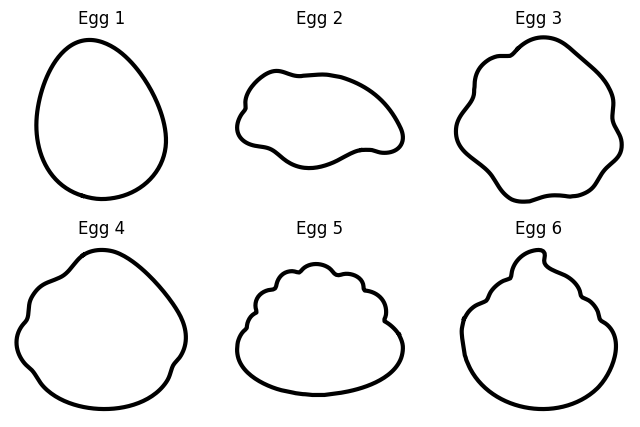

In [3]:
target_curves = np.load('target_curves.npy')

# Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')


d. Optimization Imports

In [4]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.sampling import Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

from LINKS.Optimization import DifferentiableTools, Tools

# === 0.z — Instantiate Tools (non-diff) and DifferentiableTools (diff/grad) ===
# If you already created PROBLEM_TOOLS earlier, keep it; we alias it to TOOLS for consistency.
try:
    PROBLEM_TOOLS
except NameError:
    from LINKS.Optimization import Tools
    PROBLEM_TOOLS = Tools(device='cpu')
    PROBLEM_TOOLS.compile()

TOOLS = PROBLEM_TOOLS  # make sure GD code can call TOOLS(...)

# Differentiable toolkit for gradients during GD refinement
from LINKS.Optimization import DifferentiableTools
DIFF = DifferentiableTools(device='cpu')
DIFF.compile()


e. Problem Definition (Tools + Pymoo class)

In [5]:
PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_curve, N = NODES):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.target_curve = target_curve


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target joints index
        target_idx = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                # C[i,j] = x["C" + str(j) + "_" + str(i)]
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        edges = np.array(np.where(C==1)).T
        
        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_joints = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return x0, edges, fixed_joints, motor, target_idx

    def convert_mech_to_1D(self, x0, edges, fixed_joints, target_idx=None, **kwargs):
        # This function assumes motor to be [0, 1] our random mechanism generator automatically does this
        N = self.N

        # Initialize dictionary to store 1D representation of mechanism
        x = {}

        # Store target node value
        if target_idx is None:
            target_idx = x0.shape[0]-1 # Assume last node is the target if not specified
            
        x["target"] = target_idx

        # Store connectivity matrix in its flattened form
        C = np.zeros((N,N), dtype=bool)
        C[edges[:,0], edges[:,1]] = 1
        C[edges[:,1], edges[:,0]] = 1
       
        for i in range(N):
            for j in range(i):
                x["C" + str(j) + "_" + str(i)] = C[i,j]

        del x["C0_1"]
        
        # Store position matrix in its flattened form
        if x0.shape[0] != N:
            x0 = np.pad(x0, ((0, N - x0.shape[0]), (0, 0)), 'constant', constant_values=0)
            
        for i in range(2*N):
            x["X0" + str(i)] = x0.flatten()[i]

        # Store fixed nodes in boolean vector form
        for i in range(N):
            x["fixed_nodes" + str(i)] = (i in fixed_joints) or (i>=N)

        return x

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        x0, edges, fixed_joints, motor, target_idx = self.convert_1D_to_mech(x)
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                edges,
                                fixed_joints,
                                motor,
                                self.target_curve,
                                target_idx=target_idx
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0


# 2. Initial Population

a. Imports and Helpers

In [6]:
# === Section 2 — Cell 1: Seeding utilities (single-size, early-stop, ε-dedup) ===
from LINKS.Optimization import MechanismRandomizer, Tools
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from tqdm.auto import tqdm
import numpy as np
from time import perf_counter
from collections import defaultdict

# Use the same device everywhere
TOOLS = Tools(device='cpu')
TOOLS.compile()

def epsilon_dedup(F, eps=(5e-4, 5e-3)):
    """
    Keep at most one point per epsilon-box in (distance, material) objective space.
    eps is (eps_distance, eps_material).
    """
    if len(F) == 0:
        return np.array([], dtype=int)
    keys = (np.floor(F[:,0]/eps[0]).astype(int), np.floor(F[:,1]/eps[1]).astype(int))
    seen, keep = set(), []
    for i, key in enumerate(zip(*keys)):
        if key not in seen:
            seen.add(key)
            keep.append(i)
    return np.array(keep, dtype=int)

def generate_pool_single_size(n=7, per_size=SEED_PER_SIZE, desc="Sampling mechanisms"):
    """
    Randomize mechanisms at exactly size n (to match GA encoding N=n).
    """
    t0 = perf_counter()
    pool = []
    randomizer = MechanismRandomizer(min_size=n, max_size=n, device='cpu')
    for _ in tqdm(range(per_size), desc=f"{desc} n={n}", leave=False):
        pool.append(randomizer(n=n))
    print(f"[seed] sampled {len(pool)} candidates at n={n} in {perf_counter()-t0:.1f}s")
    return pool

def evaluate_mechs(mechs, target_curve, problem, diag_every=200,
                   distance_max=0.75, material_max=10.0, max_joints=20,
                   TARGET_VALID=120):
    """
    Evaluate pool, keep only constraint-satisfying candidates, show running diagnostics.
    Early-stops once target_valid feasible candidates are collected.
    """
    t0 = perf_counter()
    X_dicts, F_list, valid = [], [], []
    size_hist = defaultdict(int)
    best = {"distance": np.inf, "material": np.inf}
    ref = np.array([distance_max, material_max])

    pbar = tqdm(total=len(mechs), desc="[eval] checking constraints", leave=False)
    for i, mech in enumerate(mechs, 1):
        x0, edges, fixed_joints, motor = mech['x0'], mech['edges'], mech['fixed_joints'], mech['motor']
        # default: last node is target
        distance, material = TOOLS(x0, edges, fixed_joints, motor, target_curve, target_idx=x0.shape[0]-1)

        best["distance"] = min(best["distance"], distance)
        best["material"] = min(best["material"], material)

        if (distance <= distance_max) and (material <= material_max) and (x0.shape[0] <= max_joints):
            X = problem.convert_mech_to_1D(x0=x0, edges=edges, fixed_joints=fixed_joints,
                                           target_idx=x0.shape[0]-1, motor=motor)
            X_dicts.append(X)
            F_list.append([distance, material])
            valid.append(mech)
            size_hist[x0.shape[0]] += 1

        if (i % diag_every == 0) or (i == len(mechs)):
            acc = len(X_dicts) / i
            pbar.set_postfix({
                "seen": i,
                "valid": len(X_dicts),
                "acc%": f"{100*acc:.1f}",
                "best_d": f"{best['distance']:.3f}",
                "best_m": f"{best['material']:.3f}"
            })
        pbar.update(1)

        # Early stop if we hit target_valid feasible seeds
        if len(X_dicts) >= TARGET_VALID:
            break

    pbar.close()

    F = np.array(F_list) if F_list else np.zeros((0,2))
    print(f"[eval] done in {perf_counter()-t0:.1f}s | valid={len(X_dicts)} "
          f"({100*len(X_dicts)/max(1, min(len(mechs), i)):.1f}%)")
    if len(X_dicts):
        print(f"[eval] valid F ranges: distance [{F[:,0].min():.3f}, {F[:,0].max():.3f}] | "
              f"material [{F[:,1].min():.3f}, {F[:,1].max():.3f}] | ref={tuple(ref)}")
        sizes_sorted = sorted(size_hist.items())
        dist_str = ", ".join([f"n={k}:{v}" for k,v in sizes_sorted])
        print(f"[eval] size distribution among valid: {dist_str}")
    return X_dicts, F, valid

def select_diverse_non_dominated(X_dicts, F, k=100, title="[seed selection]"):
    """
    1) Non-dominated filter, 2) Max-min spread selection to k.
    (Assumes ε-dedup already applied if desired.)
    """
    if len(X_dicts) == 0:
        print(f"{title} no candidates to select."); return []
    nds = NonDominatedSorting().do(F, only_non_dominated_front=True)
    X_nd, F_nd = [X_dicts[i] for i in nds], F[nds]
    print(f"{title} non-dominated front size: {len(X_nd)}")

    if len(X_nd) <= k:
        print(f"{title} selected all {len(X_nd)} (<= k={k})")
        return X_nd

    # Greedy max-min spread
    chosen = [int(np.argmin(F_nd.sum(axis=1)))]
    dist = np.linalg.norm(F_nd - F_nd[chosen[0]], axis=1)
    for _ in tqdm(range(k-1), desc=f"{title} max-min pick", leave=False):
        next_i = int(np.argmax(dist))
        chosen.append(next_i)
        dist = np.minimum(dist, np.linalg.norm(F_nd - F_nd[next_i], axis=1))
    print(f"{title} selected k={k} diverse seeds")
    return [X_nd[i] for i in chosen]



b. Generate and Evaluate Pool

In [7]:
# === Section 2 — Cell 2: Build initial pool and filter (single-size matching GA N) ===
# IMPORTANT: GA encoding and problem must use the same N below.
GA_N = NODES  # <- single place that ties N to everything downstream

# Always (re)build problem for the current curve & node count so Run All is consistent
problem = mechanism_synthesis_optimization(target_curves[curve_index], N=GA_N)

# Reset seeds so we never reuse a different-N population on Run All
initial_population = []

# Step 1: generate pool (exactly n=GA_N to avoid padding artifacts)
raw_pool = generate_pool_single_size(n=GA_N, per_size=SEED_PER_SIZE)

# Step 2: evaluate and filter with early-stop
X_dicts, F, valid_mechs = evaluate_mechs(
    raw_pool,
    target_curve=target_curves[curve_index],
    problem=problem,
    diag_every=200,
    distance_max=0.75,
    material_max=10.0,
    max_joints=20,
    TARGET_VALID=TARGET_VALID
)

# Use the evaluated dict seeds we just built (never Individuals)
initial_population = X_dicts  # may be empty; GA sampler will handle both cases

Sampling mechanisms n=7:   0%|          | 0/2000 [00:00<?, ?it/s]

[seed] sampled 2000 candidates at n=7 in 109.4s


[eval] checking constraints:   0%|          | 0/2000 [00:00<?, ?it/s]

[eval] done in 14.0s | valid=6 (0.3%)
[eval] valid F ranges: distance [0.412, 0.740] | material [5.901, 9.821] | ref=(np.float64(0.75), np.float64(10.0))
[eval] size distribution among valid: n=7:6


c. Select Initial Population

In [8]:
# === Section 2 — Cell 3: ε-dedup + pick diverse non-dominated seeds ===
# Optional ε-dedup before selecting spread to reduce near-duplicates
if len(F) > 0:
    dd_idx = epsilon_dedup(F, eps=(5e-4, 5e-3))  # tweak eps if too aggressive
    X_dd = [X_dicts[i] for i in dd_idx]
    F_dd = F[dd_idx]
else:
    X_dd, F_dd = [], F

initial_population = select_diverse_non_dominated(X_dd, F_dd, k=100, title="[seed selection]")
print(f"[seed] → init pop size: {len(initial_population)}")



[seed selection] non-dominated front size: 2
[seed selection] selected all 2 (<= k=100)
[seed] → init pop size: 2


# 3. GA Optimization

b. GA Optimization Setup

In [9]:
# === 3.b — GA sampling helper (reads current seeds at call time) ===
from pymoo.core.sampling import Sampling
from pymoo.core.mixed import MixedVariableSampling

class sample_from_seeds(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        n = int(n_samples)
        seeds = initial_population if ('initial_population' in globals() and len(initial_population) > 0) else []
        if len(seeds) > 0:
            # replicate dict seeds to fill the requested pop
            return np.array([seeds[i % len(seeds)] for i in range(n)], dtype=object)
        else:
            # safe fallback: random mixed-variable sampling
            return MixedVariableSampling().do(problem, n).get("X")


c. GA Optimization

In [10]:
# === 3.c — GA run (mixed-variable safe) ===
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.mixed import MixedVariableMating, MixedVariableDuplicateElimination
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

deduper = MixedVariableDuplicateElimination()

algorithm = NSGA2(
    pop_size=POP, #originally 100
    sampling=sample_from_seeds(),
    mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
    mutation=PolynomialMutation(prob=MUT_PROB),
    eliminate_duplicates=False                                 
)
# Optional sanity check: these must NOT be bool
print("[debug] mating deduper:", type(algorithm.mating.eliminate_duplicates))
print("[debug] algo deduper:  ", type(algorithm.eliminate_duplicates))

results = minimize(
    problem,
    algorithm,
    ('n_gen', N_GEN),
    verbose=True,
    save_history=True,
    seed=int(np.random.randint(1_000_000_000))     # fresh run-to-run seed
)





[debug] mating deduper: <class 'pymoo.core.mixed.MixedVariableDuplicateElimination'>
[debug] algo deduper:   <class 'pymoo.core.duplicate.NoDuplicateElimination'>
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      150 |    150 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      300 |    150 |  0.000000E+00 |  0.000000E+00 |  0.0236814949 |         ideal
     3 |      450 |     77 |  0.000000E+00 |  0.000000E+00 |  0.1745022931 |         ideal
     4 |      600 |     80 |  0.000000E+00 |  0.000000E+00 |  0.0202324389 |         ideal
     5 |      750 |      3 |  0.000000E+00 |  0.000000E+00 |  0.2564835599 |         ideal
     6 |      900 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |     1050 |      2 |  0.000000E+00 |  0.000000E+00 |  0.1285418320 |         ideal
     8 |     1200 |      2 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |     1350 

d. Hypervolume Check

Hyper Volume ~ 2.869207


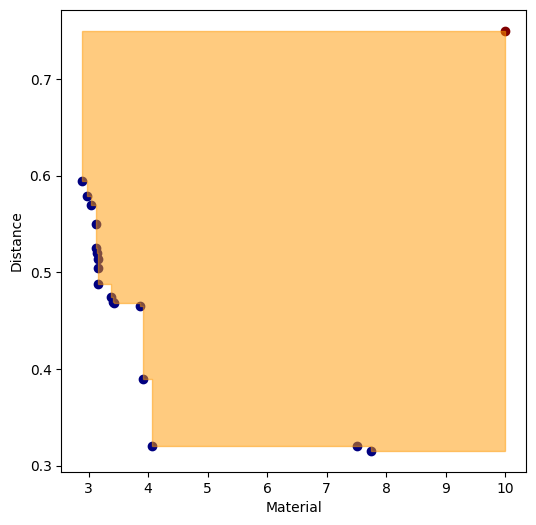

In [11]:
from LINKS.Visualization import GAVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Geometry import CurveEngine
from pymoo.indicators.hv import HV
ga_visualizer = GAVisualizer()
solver = MechanismSolver(device='cpu')
curve_engine = CurveEngine(device='cpu')

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.75, 10.0])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    ga_visualizer.plot_HV(results.F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
else:
    print('Did Not Find Solutions!!')

3E: GA multi-seed restarts (union + HV)

[3.e] seed 0: 64 pts
[3.e] seed 1: 33 pts
[3.e] seed 2: 17 pts


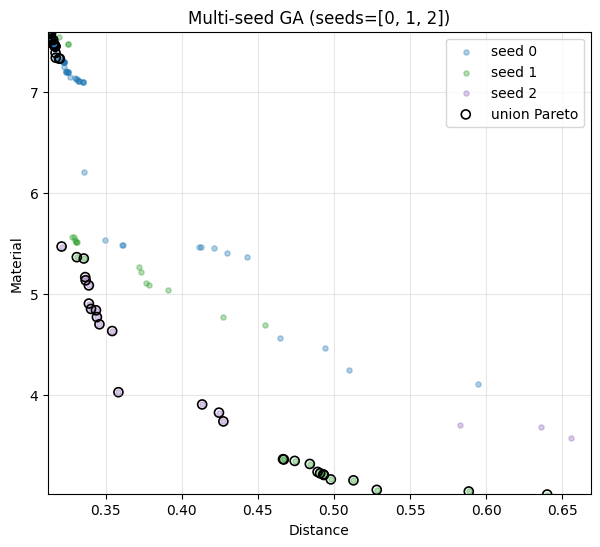

Union HV @ ref(0.75,10.0): 2.837830
[multi-seed] union Pareto size: 57


In [12]:
# === 3.e — GA Multi-Seed Restarts (union + Pareto + HV) — FIXED ===
import numpy as np, matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.mixed import MixedVariableMating, MixedVariableDuplicateElimination
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize
from pymoo.indicators.hv import HV


Seeds_List = [0] # original [0,1,2,3,4,5,6,7,11,13]

# Config (use your existing POP/N_GEN/MUT_PROB; tweak seeds if you like)
POP   = globals().get("POP", 150)
N_GEN = globals().get("N_GEN", 150)
SEEDS = globals().get("SEEDS", Seeds_List)
MUT_PROB = globals().get("MUT_PROB", 0.90)

# Reuse your 3.b helper; it falls back to random if no seeds are available
assert 'sample_from_seeds' in globals(), "sample_from_seeds() must be defined in 3.b"

# --- Build an algorithm with the safe dedup config ---
def make_algo():
    return NSGA2(
        pop_size=POP,
        sampling=sample_from_seeds(),                                # seeds if present, else random
        mating=MixedVariableMating(
            eliminate_duplicates=MixedVariableDuplicateElimination() # ✅ dedup at mating (compatible with mixed dict vars)
        ),
        mutation=PolynomialMutation(prob=MUT_PROB),
        eliminate_duplicates=False                                   # ✅ turn OFF algorithm-level dedup (prevents 'Individual.items()' crash)
    )

# Helpers to robustly extract final F/X (covers different pymoo versions)
def extract_final_F(res):
    F = getattr(res, "F", None)
    if isinstance(F, np.ndarray) and F.ndim == 2 and len(F):
        return F
    algo = getattr(res, "algorithm", None)
    if algo is not None and hasattr(algo, "pop"):
        Fp = algo.pop.get("F")
        if Fp is not None and len(Fp): return np.asarray(Fp)
    H = getattr(res, "history", None)
    if H:
        e = H[-1]
        try:
            Fh = e.opt.get("F") or e.pop.get("F")
            if Fh is not None and len(Fh): return np.asarray(Fh)
        except Exception:
            pass
    return None

def extract_final_X(res):
    X = getattr(res, "X", None)
    if isinstance(X, np.ndarray) and len(X):
        return X
    algo = getattr(res, "algorithm", None)
    if algo is not None and hasattr(algo, "pop"):
        Xp = algo.pop.get("X")
        if Xp is not None and len(Xp): return np.asarray(Xp, dtype=object)
    H = getattr(res, "history", None)
    if H:
        e = H[-1]
        try:
            Xh = e.opt.get("X") or e.pop.get("X")
            if Xh is not None and len(Xh): return np.asarray(Xh, dtype=object)
        except Exception:
            pass
    return None

def pareto_mask(F):
    F = np.asarray(F, float)
    n = len(F)
    keep = np.ones(n, dtype=bool)
    for i in range(n):
        if not np.isfinite(F[i]).all():
            keep[i] = False; continue
        for j in range(n):
            if i == j: continue
            if np.all(F[j] <= F[i]) and np.any(F[j] < F[i]):
                keep[i] = False; break
    return keep

# --- Run all seeds (no hard failure if initial_population is empty) ---
runs = []
for sd in SEEDS:
    try:
        algo = make_algo()
        res  = minimize(problem, algo, ('n_gen', N_GEN), verbose=False, seed=sd, save_history=True)
        Ffin = extract_final_F(res)
        Xfin = extract_final_X(res)
        if Ffin is None or Xfin is None:
            Ffin = np.empty((0,2)); Xfin = np.empty((0,), dtype=object)
        m = np.isfinite(Ffin).all(axis=1)
        Ffin, Xfin = Ffin[m], Xfin[m]
        runs.append((sd, Ffin, Xfin))
        print(f"[3.e] seed {sd}: {len(Ffin)} pts")
    except Exception as e:
        print(f"[3.e] seed {sd} failed: {e}")
        runs.append((sd, np.empty((0,2)), np.empty((0,), dtype=object)))

# --- Combine & Pareto-prune union ---
allF = np.vstack([F for _,F,_ in runs]) if any(len(F) for _,F,_ in runs) else np.empty((0,2))
allX = np.concatenate([X for _,_,X in runs]) if any(len(X) for _,_,X in runs) else np.empty((0,), dtype=object)

if len(allF):
    mask = pareto_mask(allF)
    UNION_F = allF[mask]
    UNION_X = allX[mask]
else:
    UNION_F = np.empty((0,2)); UNION_X = np.empty((0,), dtype=object)

# --- Plot per-seed + union front ---
plt.figure(figsize=(7,6))
colors = ['tab:blue','tab:green','tab:purple','tab:brown','tab:olive','tab:red']
for k,(sd,F,X) in enumerate(runs):
    if len(F):
        plt.scatter(F[:,0], F[:,1], s=14, alpha=0.35, color=colors[k % len(colors)], label=f"seed {sd}")
if len(UNION_F):
    plt.scatter(UNION_F[:,0], UNION_F[:,1], s=42, edgecolors='k', facecolors='none', linewidths=1.2, label="union Pareto")
    lo = np.quantile(allF, 0.02, axis=0); hi = np.quantile(allF, 0.98, axis=0)
    plt.xlim(lo[0], hi[0]); plt.ylim(lo[1], hi[1])
plt.xlabel("Distance"); plt.ylabel("Material"); plt.title(f"Multi-seed GA (seeds={SEEDS})")
plt.grid(True, alpha=0.3); 
if len(UNION_F): plt.legend()
plt.show()

# --- HV at official reference point ---
if len(UNION_F):
    hv = HV(ref_point=[0.75, 10.0])(UNION_F)
    print(f"Union HV @ ref(0.75,10.0): {hv:.6f}")
else:
    print("No finite points found across seeds.")

# --- Convert union X (dict/object) to mechanism dicts for Step 5 ---
def to_mech_list_from_X(problem, X_array):
    out = []
    for x in X_array:
        x0, e, fj, m, t = problem.convert_1D_to_mech(x)
        out.append({"x0": x0, "edges": e, "fixed_joints": fj, "motor": m, "target_joint": t})
    return out

UNION_MECHS = to_mech_list_from_X(problem, UNION_X) if len(UNION_X) else []
print(f"[multi-seed] union Pareto size: {len(UNION_MECHS)}")


3E sanity check
Compare union HV to single-run HV: higher = multi-seed helped.
Look at feasible-only HV: this is the one that matters for scoring.
Check per-seed contributions: ideally, multiple seeds contribute ≥1 union point. 

In [13]:
# === Multi-seed QA / sanity checks (put under 3.e) ===
import numpy as np
from pymoo.indicators.hv import HV

REF = np.array([0.75, 10.0])
MAX_HV = float(np.prod(REF))  # 7.5

def pareto_mask(F):
    F = np.asarray(F, float)
    n = len(F)
    keep = np.ones(n, dtype=bool)
    for i in range(n):
        if not np.isfinite(F[i]).all():
            keep[i] = False; continue
        for j in range(n):
            if i == j: continue
            if np.all(F[j] <= F[i]) and np.any(F[j] < F[i]):
                keep[i] = False; break
    return keep

# Rebuild ALL from the 'runs' you created in 3.e
allF, sizes = [], []
for sd, F, X in runs:
    allF.append(F)
    sizes.append(len(F))
ALL = np.vstack(allF) if any(sizes) else np.empty((0,2))

mask = pareto_mask(ALL) if len(ALL) else np.array([], dtype=bool)
FRONT = ALL[mask] if len(ALL) else np.empty((0,2))

# Union HV and fraction of theoretical max
hv_union = HV(ref_point=REF)(FRONT) if len(FRONT) else 0.0
print(f"Union HV @ ref {REF.tolist()}: {hv_union:.6f}  ({hv_union/MAX_HV:.1%} of max {MAX_HV:.3f})")
print(f"Union Pareto size: {len(FRONT)}")

# Feasible-only HV (challenge cares about feasible)
if len(FRONT):
    feas = (FRONT[:,0] <= REF[0]) & (FRONT[:,1] <= REF[1])
    FRONT_feas = FRONT[feas]
    hv_feas = HV(ref_point=REF)(FRONT_feas) if len(FRONT_feas) else 0.0
    print(f"Feasible-only HV: {hv_feas:.6f}  ({(hv_feas/MAX_HV if MAX_HV>0 else 0):.1%})")
    print(f"Feasible on union front: {len(FRONT_feas)}/{len(FRONT)}")
else:
    print("No union front points to evaluate feasibility.")

# Per-seed feasible HV and contributions to union front
offsets = np.cumsum([0] + sizes)  # index ranges inside ALL for each seed
contrib = np.zeros(len(runs), dtype=int)
if len(ALL):
    idxs = np.where(mask)[0]
    for idx in idxs:
        k = np.searchsorted(offsets, idx, side='right') - 1
        contrib[k] += 1

print("\nPer-seed stats:")
for i, (sd, F, X) in enumerate(runs):
    if len(F):
        Ff = F[(F[:,0] <= REF[0]) & (F[:,1] <= REF[1])]
        hv_s = HV(ref_point=REF)(Ff) if len(Ff) else 0.0
        print(f"  Seed {sd}: {len(Ff):3d}/{len(F):3d} feasible, HV={hv_s:.6f}, contributes {contrib[i]} union pts")
    else:
        print(f"  Seed {sd}: no points")


Union HV @ ref [0.75, 10.0]: 2.837830  (37.8% of max 7.500)
Union Pareto size: 57
Feasible-only HV: 2.837830  (37.8%)
Feasible on union front: 57/57

Per-seed stats:
  Seed 0:  64/ 64 feasible, HV=2.303348, contributes 26 union pts
  Seed 1:  33/ 33 feasible, HV=2.674436, contributes 17 union pts
  Seed 2:  17/ 17 feasible, HV=2.637793, contributes 14 union pts


# 4. GD Optimization

### 4.a GD Refinement (distance + material aware)

In [14]:
# === 4.0 — Gradient helpers with one-time DIFF probe and quiet numeric fallback (no name shadowing) ===
import numpy as np
from pymoo.indicators.hv import HV
from tqdm.auto import trange

# Global toggle decided at warm-up: None (unknown) -> True (use DIFF) or False (numeric)
_USE_DIFF_GRADS = None

def _ensure_shape(arr, shape):
    arr = np.asarray(arr, dtype=float)
    if arr.shape == shape:
        return arr
    if arr.size == np.prod(shape):
        return arr.reshape(shape)
    # give back as-is; caller may still use it if broadcastable
    return arr

def _numeric_grads(TOOLS, x, edges_, fj, m, target_curve, ti, h=1e-4):
    """Finite-difference grads for (distance, material) w.r.t. x.
       Works for ANY x.shape; returns grads matching x.shape."""
    x = np.asarray(x, dtype=float)
    orig_shape = x.shape

    d0, m0 = TOOLS(x, edges_, fj, m, target_curve, target_idx=ti)
    x_flat = x.ravel().copy()
    n = x_flat.size
    gd_flat = np.zeros(n, dtype=float)
    gm_flat = np.zeros(n, dtype=float)

    for k in range(n):
        xk = x_flat.copy()
        hk = h * (1.0 + abs(xk[k]))
        xk[k] += hk
        d1, m1 = TOOLS(xk.reshape(orig_shape), edges_, fj, m, target_curve, target_idx=ti)
        gd_flat[k] = (d1 - d0) / hk
        gm_flat[k] = (m1 - m0) / hk

    return float(d0), float(m0), gd_flat.reshape(orig_shape), gm_flat.reshape(orig_shape)

def _try_diff_raw(DIFF, x, edges_, fj, m, target_curve, ti):
    """Try common DIFF signatures. Return (d, mat, gd, gm) or raise."""
    # 1) __call__(..., with_grads=True)
    try:
        out = DIFF(x, edges_, fj, m, target_curve, target_idx=ti, with_grads=True)
        if isinstance(out, (tuple, list)) and len(out) >= 4:
            return out[:4]
    except TypeError:
        pass
    # 2) eval(..., with_grads=True)
    try:
        out = DIFF.eval(x, edges_, fj, m, target_curve, target_idx=ti, with_grads=True)
        if isinstance(out, (tuple, list)) and len(out) >= 4:
            return out[:4]
    except (AttributeError, TypeError):
        pass
    # 3) dedicated gradient method
    for attr in ("gradients", "grads", "evaluate_with_grads"):
        fn = getattr(DIFF, attr, None)
        if callable(fn):
            out = fn(x, edges_, fj, m, target_curve, target_idx=ti)
            if isinstance(out, (tuple, list)) and len(out) >= 4:
                return out[:4]
    # 4) plain __call__ returning 4-tuple
    out = DIFF(x, edges_, fj, m, target_curve, target_idx=ti)
    if isinstance(out, (tuple, list)) and len(out) >= 4:
        return out[:4]
    raise RuntimeError("DIFF did not return a 4-tuple")

def _get_grads(x, edges_, fj, m, target_curve, ti):
    """Unified gradient getter honoring _USE_DIFF_GRADS."""
    global _USE_DIFF_GRADS
    if _USE_DIFF_GRADS is True:
        try:
            d, mat, gd, gm = _try_diff_raw(DIFF, x, edges_, fj, m, target_curve, ti)
            gd = _ensure_shape(gd, np.asarray(x).shape)
            gm = _ensure_shape(gm, np.asarray(x).shape)
            return float(d), float(mat), gd, gm
        except Exception as exc:
            # If DIFF suddenly fails, fall back silently
            _USE_DIFF_GRADS = False
            return _numeric_grads(TOOLS, x, edges_, fj, m, target_curve, ti)
    if _USE_DIFF_GRADS is False:
        return _numeric_grads(TOOLS, x, edges_, fj, m, target_curve, ti)
    # Unknown: try DIFF once, decide the mode
    try:
        d, mat, gd, gm = _try_diff_raw(DIFF, x, edges_, fj, m, target_curve, ti)
        gd = _ensure_shape(gd, np.asarray(x).shape)
        gm = _ensure_shape(gm, np.asarray(x).shape)
        _USE_DIFF_GRADS = True
        print("[GD] Using analytic gradients from DIFF ✓")
        return float(d), float(mat), gd, gm
    except Exception as exc:
        _USE_DIFF_GRADS = False
        print(f"[GD] DIFF gradients unavailable; using numeric finite differences (reason: {exc})")
        return _numeric_grads(TOOLS, x, edges_, fj, m, target_curve, ti)

def differentiable_optimization_tools(x_list, edges_list, fj_list, m_list, target_curve, idx_list):
    """Batch evaluate distance/material + grads for a list of designs."""
    d_out, m_out, gd_out, gm_out = [], [], [], []
    for x, edges_, fj, m, ti in zip(x_list, edges_list, fj_list, m_list, idx_list):
        d, mat, gd, gm = _get_grads(x, edges_, fj, m, target_curve, ti)
        d_out.append(d); m_out.append(mat); gd_out.append(gd); gm_out.append(gm)
    return np.asarray(d_out, float), np.asarray(m_out, float), gd_out, gm_out


# === 4.a. GD Refinement (quiet + informative prints) ===
if RUN_GD and (getattr(results, "X", None) is not None):
    print("[GD] Building batch from GA results…")
    # 1) Build a small batch from GA results (top-K by distance+0.1*material when available)
    X_batch = results.X if not isinstance(results.X, dict) else [results.X]
    X_objs  = getattr(results, "F", None)

    if X_objs is not None and len(X_objs) == len(X_batch):
        order  = np.argsort(X_objs[:, 0] + 0.1 * X_objs[:, 1])[:GD_TOPK]
        X_pick = [X_batch[i] for i in order]
    else:
        X_pick = X_batch[:GD_TOPK]

    print(f"[GD] Selected {len(X_pick)} design(s) for refinement (GD_TOPK={GD_TOPK}).")

    # 2) Convert to mechanism representation
    x0s, edges, fixed_joints, motors, target_idxs = [], [], [], [], []
    for sol in (X_pick if isinstance(X_pick, (list, tuple)) else [X_pick]):
        x0, e, fj, m, t = problem.convert_1D_to_mech(sol)
        x0s.append(x0); edges.append(e); fixed_joints.append(fj); motors.append(m); target_idxs.append(t)

    # 3) Warm-up — decides whether we'll use DIFF or numeric for the whole run
    print("[GD] Warming up gradient path …")
    _ = differentiable_optimization_tools(
        [x0s[0]], [edges[0]], [fixed_joints[0]], [motors[0]],
        target_curves[curve_index], [target_idxs[0]]
    )
    mode = "DIFF analytic" if _USE_DIFF_GRADS else "numeric finite-difference"
    print(f"[GD] Gradient mode: {mode}")

    # 4) Refinement loop
    x_cur = [arr.copy() for arr in x0s]
    step  = float(GD_STEP)
    decay = float(GD_DECAY)
    ref   = np.array([0.75, 10.0], dtype=float)
    w_dist, w_mat = float(GD_W_DIST), float(GD_W_MAT)
    patience, no_improve = 25, 0

    def batch_HV(Xlist):
        F = []
        for Xi, Ei, Fj, Mi, Ti in zip(Xlist, edges, fixed_joints, motors, target_idxs):
            d, m = TOOLS(Xi, Ei, Fj, Mi, target_curves[curve_index], target_idx=Ti)
            F.append([d, m])
        F = np.asarray(F, float)
        F = F[np.isfinite(F).all(axis=1)]
        return (HV(ref_point=ref)(F) if len(F) else 0.0), F

    hv_best, _ = batch_HV(x_cur)
    x_best = [arr.copy() for arr in x_cur]
    print(f"[GD] Start HV: {hv_best:.6f}  | step={step:.2e}  (w_dist={w_dist}, w_mat={w_mat})")

    def _normalize(v):
        n = np.linalg.norm(v)
        return v / n if n > 0 else v

    LOG_EVERY = max(1, GD_STEPS // 10)  # ≈10 logs

    for it in trange(GD_STEPS, desc="[GD-lite]"):
        d_arr, m_arr, g_d_list, g_m_list = differentiable_optimization_tools(
            x_cur, edges, fixed_joints, motors, target_curves[curve_index], target_idxs
        )

        # Weighted descent direction per design
        dirs = []
        for gd_i, gm_i in zip(g_d_list, g_m_list):
            g = w_dist * gd_i + w_mat * (gm_i / 10.0)   # scale material grad
            dirs.append(_normalize(g))

        # Take a step
        for i in range(len(x_cur)):
            if dirs[i].shape != np.asarray(x_cur[i]).shape:
                print(f"[GD][warn] dir shape {dirs[i].shape} != x shape {np.asarray(x_cur[i]).shape}; attempting broadcast.")
            x_cur[i] = x_cur[i] - step * dirs[i]

        # Evaluate HV and manage patience/decay
        hv_now, _ = batch_HV(x_cur)
        improved = hv_now > hv_best + 1e-12
        if improved:
            hv_best = hv_now
            x_best = [arr.copy() for arr in x_cur]
            no_improve = 0
        else:
            no_improve += 1
            if no_improve % 5 == 0:
                # small nudge toward best set
                for i in range(len(x_cur)):
                    x_cur[i] = 0.5 * x_cur[i] + 0.5 * x_best[i]

        if no_improve >= patience:
            old_step = step
            step *= decay
            no_improve = 0
            print(f"[GD] patience hit → decreasing step: {old_step:.2e} → {step:.2e}")

        if ((it + 1) % LOG_EVERY == 0) or (it == 0):
            print(f"[GD] it={it+1:4d}/{GD_STEPS}  HV={hv_now:.6f}  best={hv_best:.6f}  step={step:.2e}")

    hv_final, _ = batch_HV(x_best)
    print(f"[GD] Done. Best HV: {hv_best:.6f} | Final HV (best set): {hv_final:.6f} | K={len(x_best)}")

    # Export refined set for Step 5 if you need it downstream
    GD_REFINED_X0S = x_best
else:
    print("[GD] Skipped (RUN_GD is False or results.X is None).")


[GD] Building batch from GA results…
[GD] Selected 10 design(s) for refinement (GD_TOPK=10).
[GD] Warming up gradient path …
[GD] DIFF gradients unavailable; using numeric finite differences (reason: too many indices for array: array is 1-dimensional, but 2 were indexed)
[GD] Gradient mode: numeric finite-difference
[GD] Start HV: 2.817256  | step=3.00e-04  (w_dist=0.7, w_mat=0.3)


[GD-lite]:   0%|          | 0/200 [00:00<?, ?it/s]

[GD] it=   1/200  HV=2.846409  best=2.846409  step=3.00e-04
[GD] it=  20/200  HV=2.960615  best=2.960615  step=3.00e-04
[GD] it=  40/200  HV=2.976615  best=2.976615  step=3.00e-04
[GD] it=  60/200  HV=2.988883  best=2.988883  step=3.00e-04
[GD] it=  80/200  HV=3.004002  best=3.004002  step=3.00e-04
[GD] it= 100/200  HV=3.021095  best=3.021095  step=3.00e-04
[GD] it= 120/200  HV=3.037922  best=3.037922  step=3.00e-04
[GD] it= 140/200  HV=3.054932  best=3.054932  step=3.00e-04
[GD] it= 160/200  HV=3.071726  best=3.071726  step=3.00e-04
[GD] it= 180/200  HV=3.087299  best=3.087299  step=3.00e-04
[GD] it= 200/200  HV=3.102468  best=3.102468  step=3.00e-04
[GD] Done. Best HV: 3.102468 | Final HV (best set): 3.102468 | K=10


# 5. Compare and Save Improved Solutions (per curve)

In [15]:
# Step 5 (patched): sanitize → validate → score (no zeros surprise) ===
import numpy as np, os
from copy import deepcopy
from LINKS.CP import make_empty_submission, evaluate_submission

REF_DMAX, REF_MMAX = 0.75, 10.0

def _to_builtin(obj):
    """Recursively convert numpy types/arrays to pure Python."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.floating, np.integer)):
        return obj.item()
    if isinstance(obj, (list, tuple)):
        return [_to_builtin(x) for x in obj]
    if isinstance(obj, dict):
        return {k: _to_builtin(v) for k, v in obj.items()}
    return obj

def _sanitize_mech(mech):
    """Ensure mechanism dict is JSON-serializable with expected field types."""
    m = deepcopy(mech)
    for k in list(m.keys()):
        m[k] = _to_builtin(m[k])

    # Optional strict casts for indices
    if "motor" in m:
        # motor may be a list/array of two ints [0,1]; enforce ints
        m["motor"] = [int(v) for v in m["motor"]]
    if "target_joint" in m and not isinstance(m["target_joint"], int):
        m["target_joint"] = int(m["target_joint"])
    return m

def _validate_mechs(cands, target_curve, label="cands", print_first=5):
    """Return indices of feasible candidates and summary stats."""
    ok, bad, stats = [], [], []
    for i, mech in enumerate(cands):
        try:
            x0 = np.asarray(mech["x0"], float)
            e  = np.asarray(mech["edges"], int)
            fj = np.asarray(mech["fixed_joints"], int)
            m  = mech["motor"]
            tj = mech["target_joint"]

            d, mat = TOOLS(x0, e, fj, m, target_curve, target_idx=tj)
            finite = np.isfinite(d) and np.isfinite(mat)
            feasible = finite and (d <= REF_DMAX) and (mat <= REF_MMAX)
            stats.append((i, float(d), float(mat), finite, feasible))
            (ok if feasible else bad).append(i)
        except Exception as exc:
            stats.append((i, np.nan, np.nan, False, False))
            bad.append(i)

    print(f"[step5] {label}: feasible {len(ok)}/{len(cands)} "
          f"(will send only feasible to scorer)")
    for i, d, mat, finite, feas in stats[:print_first]:
        print(f"  idx={i:3d}  d={d:.4f}  m={mat:.4f}  finite={finite}  feasible={feas}")
    return ok, bad, stats

def _dedup_structural(mechs):
    """Simple dedup by structure (edges + target). Keeps first occurrence."""
    seen, kept = set(), []
    for m in mechs:
        edges_norm = tuple(sorted(tuple(map(int, pair)) for pair in m["edges"]))
        key = (edges_norm, int(m["target_joint"]))
        if key not in seen:
            seen.add(key); kept.append(m)
    return kept

# ---- Build candidate list from available sources
cand_raw = []
if 'UNION_MECHS' in globals() and len(UNION_MECHS):
    print(f"[step5-prep] Taking {len(UNION_MECHS)} from UNION_MECHS")
    cand_raw.extend(UNION_MECHS)
if 'GD_REFINED_X0S' in globals() and len(GD_REFINED_X0S):
    # If you want: wrap refined x0s back into full mech dicts using the last GA structures.
    # Here we skip unless you store paired structures. Uncomment if you have a mapping.
    # print(f"[step5-prep] Also adding {len(GD_REFINED_X0S)} GD-refined designs")
    pass

assert len(cand_raw) > 0, "candidate_list is empty — nothing to score."

# ---- Sanitize → Dedup
cand_san = [_sanitize_mech(m) for m in cand_raw]
cand_san = _dedup_structural(cand_san)
print(f"[step5-prep] After sanitize+dedup: {len(cand_san)} candidates")

# ---- Validate against this curve and keep only feasible (scorer ignores infeasible anyway)
ok_idx, bad_idx, stats = _validate_mechs(cand_san, target_curves[curve_index], label="sanitized")
cand_feas = [cand_san[i] for i in ok_idx]
if len(cand_feas) == 0:
    print("[step5] No feasible candidates remain → scorer would return 0. "
          "Re-check GA/GD outputs and constraints.")
    # fall back to finite (even if infeasible) so you can still inspect scoring behavior
    finite_idx = [i for i,(j,d,m,finite,feas) in enumerate(stats) if np.isfinite(d) and np.isfinite(m)]
    cand_feas = [cand_san[i] for i in finite_idx[:1000]]
    print(f"[step5] Falling back to {len(cand_feas)} finite (but not necessarily feasible) for debugging.")

# ---- Score: compare to saved and print decision
ci = int(curve_index) + 1  # 1-based
key = f"Problem {ci}"
print(f"[step5] Scoring {len(cand_feas)} candidate(s) for {key}")

# current saved score
if os.path.exists("my_submission.npy"):
    saved = np.load("my_submission.npy", allow_pickle=True).item()
    saved_list = saved.get(key, [])
    saved_payload = {**make_empty_submission(), key: saved_list} if saved_list else make_empty_submission()
    saved_score = evaluate_submission(saved_payload)["Score Breakdown"].get(key, 0.0)
else:
    saved = {}
    saved_score = 0.0

# candidate score (cap to 1000 as per rules)
cand_payload = {**make_empty_submission(), key: cand_feas[:1000]}
cand_score   = evaluate_submission(cand_payload)["Score Breakdown"].get(key, 0.0)

print(f"Saved score for {key}:     {saved_score:.6f}")
print(f"Candidate (union) score:   {cand_score:.6f}")
print("Will update:", cand_score > saved_score + 1e-12)

# ---- If better, save merged (union old + new) → Pareto prune by objectives within constraints
def _pareto_mask(F):
    F = np.asarray(F, float); n = len(F)
    keep = np.ones(n, dtype=bool)
    for i in range(n):
        if not np.isfinite(F[i]).all(): keep[i] = False; continue
        for j in range(n):
            if i == j: continue
            if np.all(F[j] <= F[i]) and np.any(F[j] < F[i]):
                keep[i] = False; break
    return keep

if cand_score > saved_score + 1e-12:
    merged = (saved.get(key, []) if key in saved else []) + cand_feas
    # keep feasible only
    feas_idx, _, _ = _validate_mechs(merged, target_curves[curve_index], label="merged", print_first=0)
    merged = [merged[i] for i in feas_idx]

    # Pareto prune by (distance, material) evaluated via TOOLS
    F = []
    for mech in merged:
        x0 = np.asarray(mech["x0"], float)
        e  = np.asarray(mech["edges"], int)
        fj = np.asarray(mech["fixed_joints"], int)
        m  = mech["motor"]
        tj = mech["target_joint"]
        d, mat = TOOLS(x0, e, fj, m, target_curves[curve_index], target_idx=tj)
        F.append([d, mat])
    F = np.asarray(F, float)
    mask = _pareto_mask(F)
    merged = [mech for mech, keep in zip(merged, mask) if keep]

    # cap to 1000
    merged = merged[:1000]

    new_payload = make_empty_submission()
    new_payload[key] = merged
    new_score = evaluate_submission(new_payload)["Score Breakdown"].get(key, 0.0)

    print(f"[step5] Merged+pruned feasible set: {len(merged)} | New score: {new_score:.6f}")

    # persist
    saved[key] = merged
    np.save("my_submission.npy", saved, allow_pickle=True)
    print("[step5] Saved my_submission.npy ✓")
else:
    print("[step5] Not saving; candidate didn’t beat current.")


[step5-prep] Taking 57 from UNION_MECHS
[step5-prep] After sanitize+dedup: 4 candidates
[step5] sanitized: feasible 4/4 (will send only feasible to scorer)
  idx=  0  d=0.3168  m=7.4575  finite=True  feasible=True
  idx=  1  d=0.3120  m=7.7710  finite=True  feasible=True
  idx=  2  d=0.6402  m=3.0099  finite=True  feasible=True
  idx=  3  d=0.3311  m=5.3641  finite=True  feasible=True
[step5] Scoring 4 candidate(s) for Problem 2
Saved score for Problem 2:     2.932863
Candidate (union) score:   2.247574
Will update: False
[step5] Not saving; candidate didn’t beat current.


### 5.b. Evaluate Submission Check

In [16]:
import numpy as np
from LINKS.CP import evaluate_submission

# Load your submission (dict saved with np.save earlier)
submission = np.load("my_submission.npy", allow_pickle=True).item()

# Evaluate and print scores
score = evaluate_submission(submission)
print(score)


{'Overall Score': 3.4236018867640143, 'Score Breakdown': {'Problem 1': 4.9951039703176825, 'Problem 2': 2.9328630015500465, 'Problem 3': 3.1251822811640793, 'Problem 4': 3.651364129841369, 'Problem 5': 3.0138020538229, 'Problem 6': 2.823295883888008}}


### 5.c. Extra: Save File as Markdown

In [17]:
# === Save this notebook as Markdown (same base name) — robust version ===
import os, sys, time, nbformat
from nbconvert import MarkdownExporter

def _detect_notebook_path():
    # 1) Try ipynbname (most reliable when it works)
    try:
        import ipynbname
        return str(ipynbname.path())
    except Exception:
        pass
    # 2) VS Code sometimes exposes this env var; fallback to cwd listing
    for name in os.listdir():
        if name.endswith(".ipynb"):
            return os.path.abspath(name)
    raise RuntimeError("Could not detect .ipynb path. Please save and rerun, or set NB_PATH manually.")

try:
    NB_PATH = _detect_notebook_path()
    BASE, _ = os.path.splitext(NB_PATH)
    MD_PATH = BASE + ".md"
    ASSETS_DIR = BASE + "_files"  # nbconvert's default assets folder naming

    # Load the *saved* notebook file
    with open(NB_PATH, "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    # Export to Markdown, capturing resources (images, figs)
    md_exporter = MarkdownExporter(exclude_input_prompt=True, exclude_output_prompt=True)
    body, resources = md_exporter.from_notebook_node(nb)

    # Write markdown
    with open(MD_PATH, "w", encoding="utf-8") as f:
        f.write(body)

    # Write assets (if any)
    if resources.get("outputs"):
        os.makedirs(ASSETS_DIR, exist_ok=True)
        for filename, data in resources["outputs"].items():
            with open(os.path.join(ASSETS_DIR, filename), "wb") as f:
                f.write(data)

    # Helpful debug info
    n_cells = sum(1 for _ in nb["cells"])
    mtime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(os.path.getmtime(NB_PATH)))
    print("✅ Exported")
    print(f"  Source: {NB_PATH}")
    print(f"  Saved:  {MD_PATH}")
    print(f"  Assets: {ASSETS_DIR} ({len(resources.get('outputs', {}))} files)")
    print(f"  Cells:  {n_cells}")
    print(f"  Note: export reflects on-disk content last saved at {mtime}. Save notebook first.")
except Exception as e:
    print("[export failed]", e)
    print("Tip: Save the notebook, ensure it has a .ipynb filename, then rerun this cell.")


✅ Exported
  Source: c:\Users\smuti\OneDrive\Desktop\CM_3D-Pen\2155-Optimization-Challenge-Problem\z_Challegen-Problem-1_SM-BA_v5.ipynb
  Saved:  c:\Users\smuti\OneDrive\Desktop\CM_3D-Pen\2155-Optimization-Challenge-Problem\z_Challegen-Problem-1_SM-BA_v5.md
  Assets: c:\Users\smuti\OneDrive\Desktop\CM_3D-Pen\2155-Optimization-Challenge-Problem\z_Challegen-Problem-1_SM-BA_v5_files (3 files)
  Cells:  41
  Note: export reflects on-disk content last saved at 2025-10-01 03:50:43. Save notebook first.


code: 9999999999999999999999999999999999999999999